# CITS55508 Assignment 3

- Author: Joo Kai Tay (22489437)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Importing useful libraries
import numpy as np
import os
import copy
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 1. A model for diagnosing cancer

In [2]:
# load the dataset
breast_cancer = pd.read_csv('breast-cancer.csv')

In [3]:
from sklearn.preprocessing import OrdinalEncoder

# Creating an instance of the ordinal encoder. Malignant = 0, Benign = 1
enc = OrdinalEncoder(categories=[['B','M']])
breast_cancer['diagnosis'] = enc.fit_transform(breast_cancer['diagnosis'].values.reshape(-1,1))

breast_cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


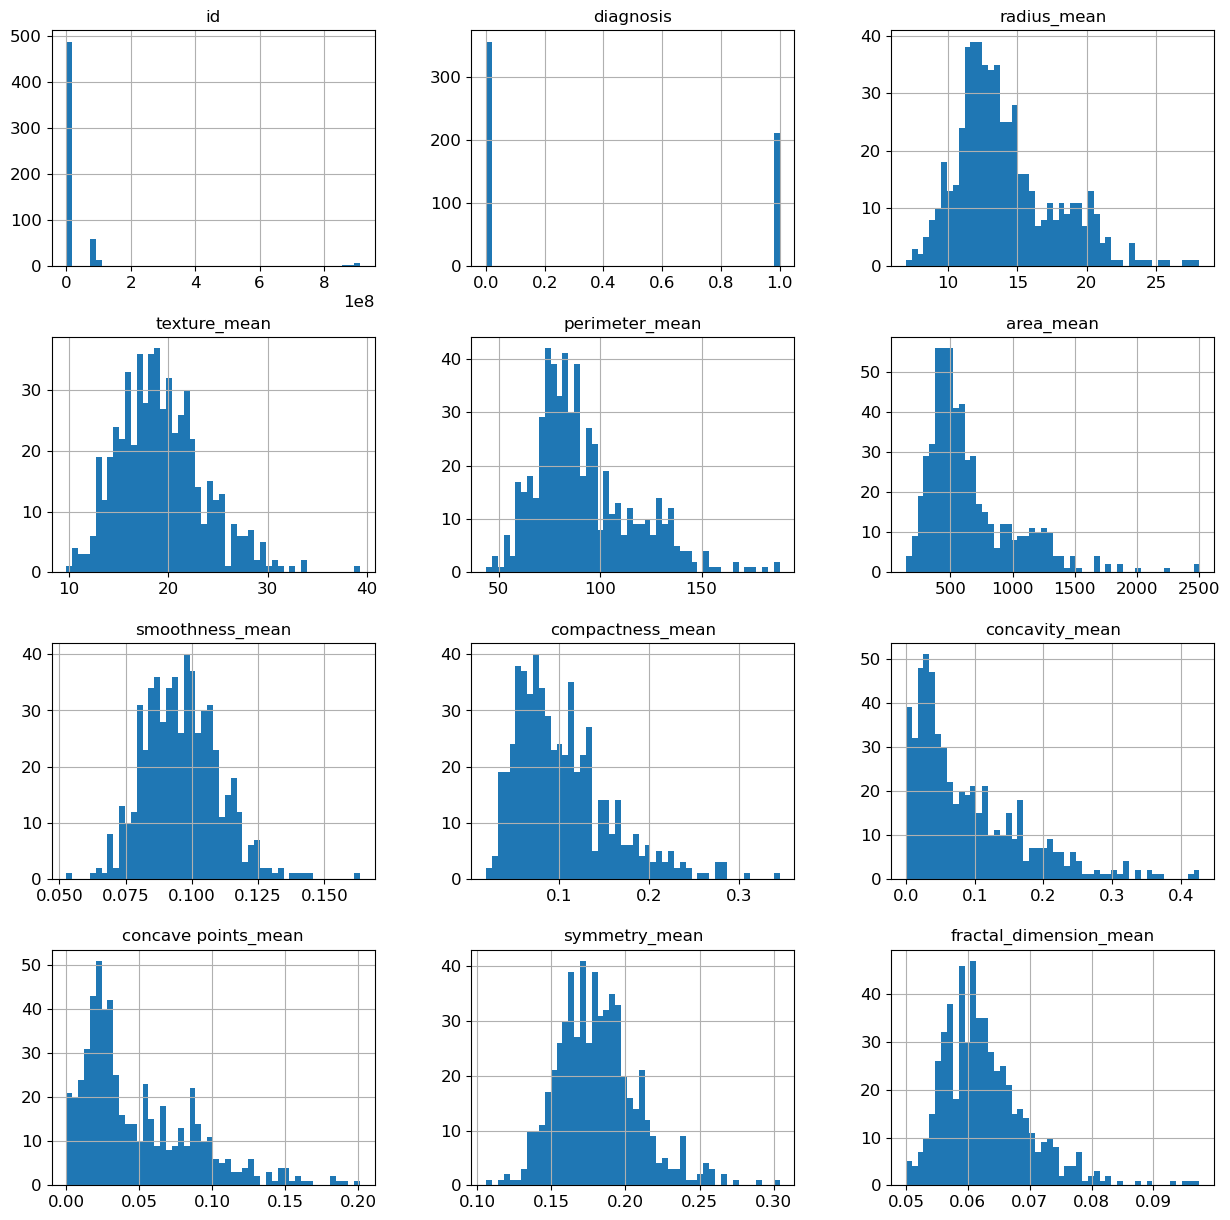

In [4]:
breast_cancer.hist(bins=50, figsize=(15,15))
plt.show()

The plot above shows a histogram of the features in the dataset. It can be seen that there are a significant nummber of features in this dataset with a right skew. This could potentially affect the accuracy of our machine learning algorithm. The features need to be scaled before being fed into the machine learning algorithm.

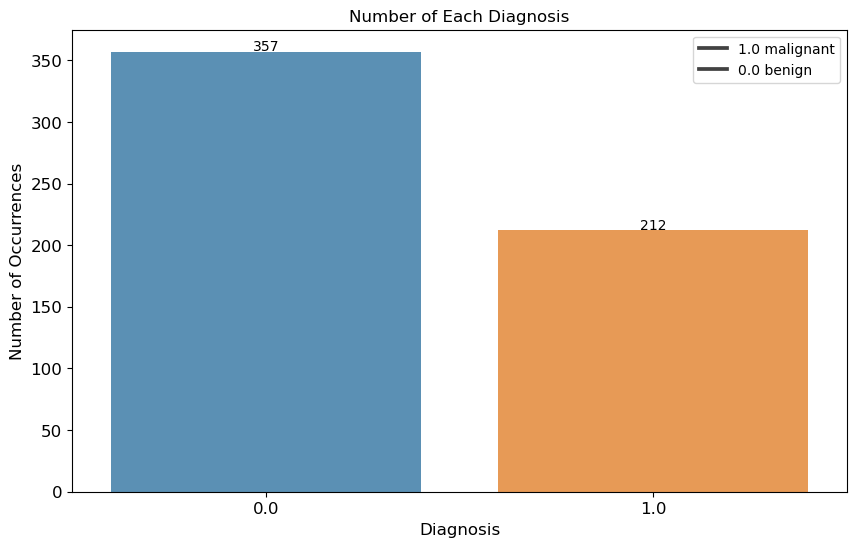

In [5]:
import seaborn as sns

# Count the number of each class
class_balance = breast_cancer['diagnosis'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_balance.index, y=class_balance.values, alpha=0.8)

plt.title('Number of Each Diagnosis')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Diagnosis', fontsize=12)

# Add count labels to the top of each bar
for i, v in enumerate(class_balance.values):
    plt.text(i, v + 10, str(v), ha='center', va='top')

# Add legend
plt.legend(labels=['1.0 malignant', '0.0 benign'])

plt.show()

The plot above shows the number of diagnosis for malignant and benign in our breast cancer dataset. It can be observed from the plot that there are significantly more examples of benign tumors when compared to malignant tumors. This could cause bias in both the logistic regression and decision tree classifiers in later steps.

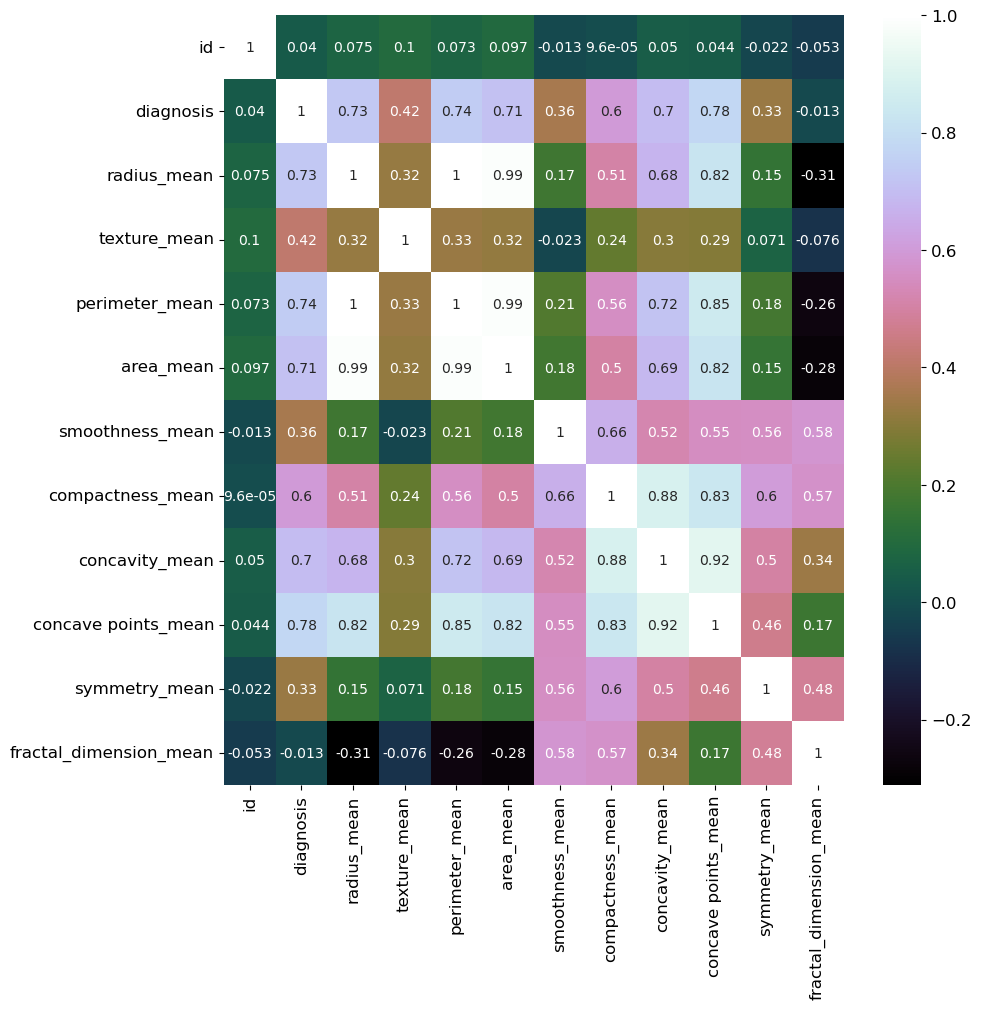

In [6]:
plt.figure(figsize=(10, 10))
sns.heatmap(breast_cancer.corr(), cmap='cubehelix', annot=True)
plt.show()

The cell above shows the correlation matrix for the Breast Cancer Wisconsin (diagnostic) dataset. It can be observed that there are a significant number of highly correlated features in the dataset. This will be important in further discussions in section 1.2.2.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = breast_cancer.drop(['diagnosis', 'id'], axis=1)
y = breast_cancer['diagnosis']

cn_train_X, cn_test_X, cn_train_y, cn_test_y = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
cn_train_X = scaler.fit_transform(cn_train_X)
cn_test_X = scaler.transform(cn_test_X)

cn_train_X = pd.DataFrame(cn_train_X, columns=X.columns)
cn_test_X = pd.DataFrame(cn_test_X, columns=X.columns)

# 1.1 Task 1: Training Models

### 1.1.1 Training Logistic Regression Classifier

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'solver': ['newton-cg', 'lbfgs'], 
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    },
    {
        'solver': ['liblinear'], 
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    }
]

grid_search = GridSearchCV(LogisticRegression(random_state=123, max_iter=400), param_grid, cv=3, scoring='recall') 

# Train the models
grid_search.fit(cn_train_X, cn_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best cross-validation score: 0.9052840434419381


In [9]:
log_reg = LogisticRegression(solver='newton-cg', penalty='l2', C=100, random_state=123)
log_reg.fit(cn_train_X, cn_train_y)
y_pred_log = log_reg.predict(cn_test_X)

print(classification_report(cn_test_y, y_pred_log))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95        71
         1.0       0.91      0.93      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



The cell above shows the grid search to find the best hyperparameters for the logistic regression classifier. 3 hyperparameters are being tuned in this search:
- solver: Algorithm to use in the optimization problem. We are choosing between lbfgs, which is the default solver and liblinear, which performs well on small datasets. 
- penalty: The penalty applied to the algorithm
- C: Controls the inverse of the regularization strength. Smaller values of C increase regularization, reducing the risk of overfitting.


The scoring method chosen for this grid search is recall, not accuracy. It was observed in an earlier plot that the dataset is not balanced. Accuracy calculates the overall correctness of predictions by considering the ratio of correctly classified instances to the total number of instances. However, in imbalanced datasets, where one class is significantly more prevalent than the other, accuracy can be misleading.

Recall is defined as the ratio of true positives (TP) to the sum of true positives and false negatives (FN). When considering the cancer dataset, we want a classifier with as high a recall as possible. A high recall value indicates that the model is correctly identifying a large proportion of the positive instances. In terms of the cancer dataset, a true positive would mean a malignant tumor while a false negative would mean a malignant tumor that was falsely classified as benign. We do not want any false negatives as a missed cancer diagnosis could be potentially fatal to the patient. Therefore, recall was chosen as the scoring metic. 

Based on this, the best hyperparameters are:
- solver: newton-cg
- penalty: l2
- C: 100

The accuracy, precision and recall will be discussed in section 1.1.3

### 1.1.2 Training Decision Tree Classifier

In [10]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 5, 7, 9],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [None, 'sqrt', 'log2'],
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid, cv=3, scoring='recall') 

# Train the models
grid_search.fit(cn_train_X, cn_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.922827903091061


In [11]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=123)
tree.fit(cn_train_X, cn_train_y)
y_pred_tree = tree.predict(cn_test_X)

print(classification_report(cn_test_y, y_pred_tree))

              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93        71
         1.0       0.84      0.95      0.89        43

    accuracy                           0.91       114
   macro avg       0.90      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114



The cell above shows the grid search to find the best hyperparameters for the Decision Tree classifier. 5 hyperparameters are being tuned in this search:

- criterion:  Decision trees use a criterion to measure the quality of a split at each node. The two common options are 'gini' and 'entropy'. Tuning this hyperparameter allows the model to select the criterion that results in the best splits, leading to more accurate and informative decision trees.
- max_depth: This hyperparameter determines the maximum depth or levels allowed in the decision tree. Tuning max_depth helps control the complexity of the tree. A shallow tree (low max_depth) may underfit the data, while a deep tree (high max_depth) can overfit. By trying different values, the optimal depth can be found that balances between capturing useful patterns and avoiding excessive complexity.
- min_samples_split: This hyperparameter sets the minimum number of samples required to split an internal node. By tuning min_samples_split, you control the threshold for splitting nodes. Smaller values can result in more partitions, potentially capturing more specific patterns but increasing the risk of overfitting. Larger values promote generalization by requiring a higher number of samples for node splitting.
- min_samples_leaf: Similar to min_samples_split, min_samples_leaf sets the minimum number of samples required to be at a leaf node. It controls the granularity of the decision tree. Smaller values allow the tree to capture more specific patterns but can lead to overfitting, while larger values promote generalization but may result in underfitting.
- max_features: This hyperparameter determines the maximum number of features to consider when looking for the best split. By trying different options such as 'sqrt' (square root of the total features) or 'log2' (log base 2 of the total features), you can control the randomness of feature selection during tree building. Tuning max_features helps to reduce overfitting and improve the model's ability to generalize.

The scoring used is `recall` detailed reasoning was explained in section 1.1.1.

The best hyperparameters from the grid search:
- criterion: entropy
- max_depth: 2
- min_samples_split: 2
- min_samples_leaf: 1
- max_features: None

The results from this classifier will be discussed in section 1.1.3

### 1.1.3 Comparing Logistic Regression and Decision Tree Classifiers

In [12]:
def plot_accuracy(y_pred_1, y_pred_2, name1, name2, flag):
    colors = ['#8dd3c7', '#bebada']
    if flag == 'train':
        accuracy_score1 = accuracy_score(cn_train_y, y_pred_1)
        accuracy_score2 = accuracy_score(cn_train_y, y_pred_2)
    elif flag == 'test':
        accuracy_score1 = accuracy_score(cn_test_y, y_pred_1)
        accuracy_score2 = accuracy_score(cn_test_y, y_pred_2)
        
    # Create a bar chart
    plt.figure(figsize=(6, 4))
    plt.bar([name1, name2], [accuracy_score1, accuracy_score2], alpha=0.8, color=colors)

    plt.title('Accuracy comparison ' + flag + ' set')
    plt.ylabel('Accuracy')
    plt.xlabel('Classifiers')

    # Add value labels to the top of each bar
    for i, v in enumerate([accuracy_score1, accuracy_score2]):
        plt.text(i, v + 0.01, str(v), ha='center', va='bottom')

    plt.show()

In [13]:
from sklearn.metrics import precision_score, recall_score

def plot_precision_recall(y_pred_1, y_pred_2, name1, name2, flag):
    # Define the colors for the bars
    colors = ['#8dd3c7', '#bebada']

    # Calculate precision scores based on the flag
    if flag == 'train':
        accuracy_score1 = precision_score(cn_train_y, y_pred_1)
        accuracy_score2 = precision_score(cn_train_y, y_pred_2)
    elif flag == 'test':
        accuracy_score1 = precision_score(cn_test_y, y_pred_1)
        accuracy_score2 = precision_score(cn_test_y, y_pred_2)
    
    # Create the first subplot for precision comparison
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].bar([name1, name2], [accuracy_score1, accuracy_score2], alpha=0.8, color=colors)
    axs[0].set_title('Precision comparison ' + flag + ' set')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Classifiers')
    
    # Add value labels to the top of each bar
    for i, v in enumerate([accuracy_score1, accuracy_score2]):
        axs[0].text(i, v + 0.01, str(v), ha='center', va='bottom')

    # Calculate recall scores based on the flag
    if flag == 'train':
        accuracy_score1 = recall_score(cn_train_y, y_pred_1)
        accuracy_score2 = recall_score(cn_train_y, y_pred_2)
    elif flag == 'test':
        accuracy_score1 = recall_score(cn_test_y, y_pred_1)
        accuracy_score2 = recall_score(cn_test_y, y_pred_2)

    # Create the second subplot for recall comparison
    axs[1].bar([name1, name2], [accuracy_score1, accuracy_score2], alpha=0.8, color=colors)
    axs[1].set_title('Recall comparison ' + flag + ' set')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Classifiers')

    # Add value labels to the top of each bar
    for i, v in enumerate([accuracy_score1, accuracy_score2]):
        axs[1].text(i, v + 0.01, str(v), ha='center', va='bottom')

    # Adjust the layout and display the plots
    plt.tight_layout()
    plt.show()

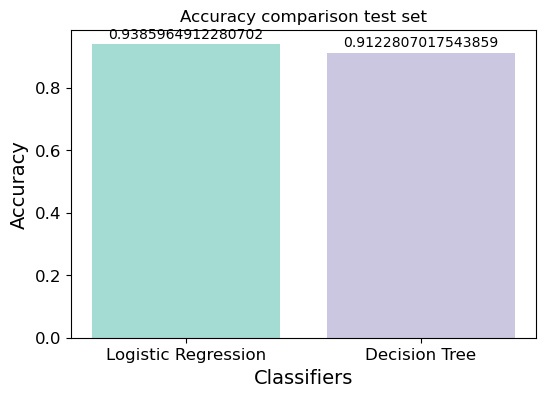

In [14]:
plot_accuracy(y_pred_log, y_pred_tree, 'Logistic Regression', 'Decision Tree', 'test')

Accuracy represents the proportion of correctly classified instances out of the total number of instances in a dataset. To calculate accuracy, you compare the predicted labels generated by the algorithm to the true labels of the dataset. The algorithm assigns a predicted label to each instance based on the learned patterns and features from the training data. The accuracy is then determined by dividing the number of correctly predicted instances by the total number of instances:

Accuracy = (Number of correctly predicted instances) / (Total number of instances)

As mentioned before, accuracy is a useful metric when the dataset is well-balanced. In our situation, although the logistic regression classifier has a sligtly higher accuracy when compared to the decision tree clasifier, this in inconclusive and we will not use it in our selection of a best classifier. 

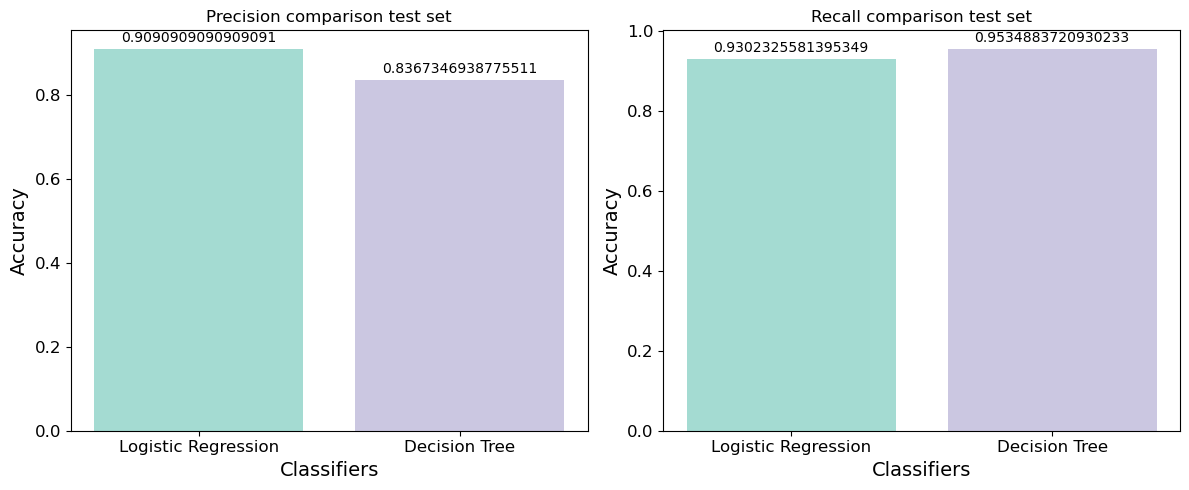

In [15]:
plot_precision_recall(y_pred_log, y_pred_tree, 'Logistic Regression', 'Decision Tree', 'test')

The plot above shows the comparison of the precision and recall of the two classifiers.

Precision is defined as the ratio of true positives (TP) to the sum of true positives and false positives (FP):

Precision = TP / (TP + FP)

In other words, precision measures the proportion of correct positive predictions out of all the positive predictions made by the model. A high precision value indicates that the model is making very few false positive predictions. In terms of the cancer dataset, a true positive would mean a malignant tumor while a false positive would mean a benign tumor that was falsely classified as malignant.

Precision is particularly important when the cost of false positives is high. In this case, this is not true. While it can be argued that a false positive prediction could cause additional stress to the patient, additional tests can be performed that shows that the patient is indeed benign.

Contary to the data, for the cancer dataset we would actually prefer the decision tree classifier with it's lower precision. It is more important for us to catch 100% of the malignant diagnoses.

Recall is defined as the ratio of true positives (TP) to the sum of true positives and false negatives (FN):

Recall = TP / (TP + FN)

 When considering the cancer dataset, we want a classifier with as high a recall as possible. A high recall value indicates that the model is correctly identifying a large proportion of the positive instances. In terms of the cancer dataset, a true positive would mean a malignant tumor while a false negative would mean a malignant tumor that was falsely classified as benign. 

Based on our needs, we would prefer the decision tree classifier as it has a higher recall (0.95) when compared to the logistic regression classifier (0.93). We want to capture all the true positives while avoiding false negatives so as to avoid patients who have malignant tumors slipping through. 

## 1.2 Task 2: High Imact Features

### 1.2.1 Logistic Regression Classifier

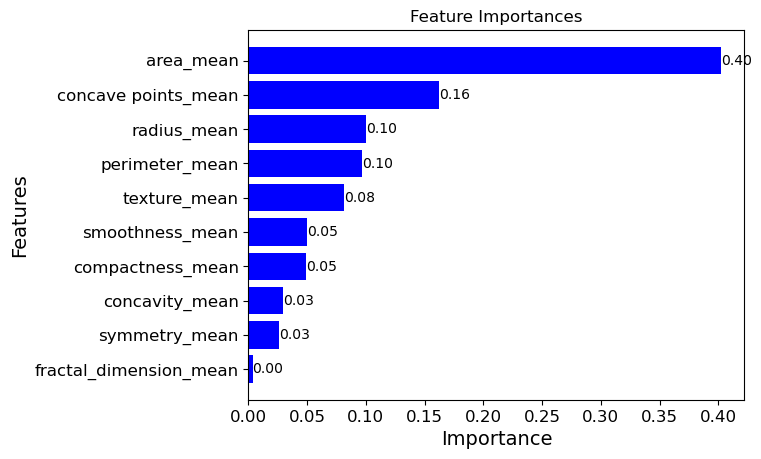

In [16]:
# Get the absolute magnitudes of the coefficients
coef_magnitudes = np.abs(log_reg.coef_[0])

# Normalize the magnitudes
norm_coef_magnitudes = coef_magnitudes / np.sum(coef_magnitudes)

# Sort the features by their normalized magnitudes in descending order
sorted_features = sorted(zip(cn_train_X.columns, norm_coef_magnitudes), key=lambda x: x[1], reverse=True)

# Extract the feature names and magnitudes in the reversed order
features, magnitudes = zip(*sorted_features[::-1])

# Set the color for zero coefficients
color_map = ['red' if magnitude == 0 else 'blue' for magnitude in magnitudes]

# Plot the feature importances
fig, ax = plt.subplots()
bars = ax.barh(range(len(features)), magnitudes, color=color_map)
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')

# Add values at the end of each bar
for i, bar in enumerate(bars):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{magnitudes[i]:.2f}',
            ha='left', va='center', color='black')

plt.show()

The plot above shows the feature importances as determined by the logistic regression classifier. In a logistic regression model, feature importances are typically not directly available like in some other models such as decision trees or random forests. Therefore, we will determine the importance of features by examining the coefficients associated with each feature.

It can be observed from the plot that the coefficients for area_mean is 0.40 and concave points_mean is 0.16. These two features account for over half of the feature importance in the model, with area_mean being particularly impactful. It can be noted that fractal_dimension_mean has a weight of 0. Having zero coefficients means that the corresponding features have no influence on the predicted probabilities or decisions made by the logistic regression model. These features can be considered as effectively excluded from the model and can be omitted in further analysis or model interpretation.

### 1.2.2 Decision Tree Classifier

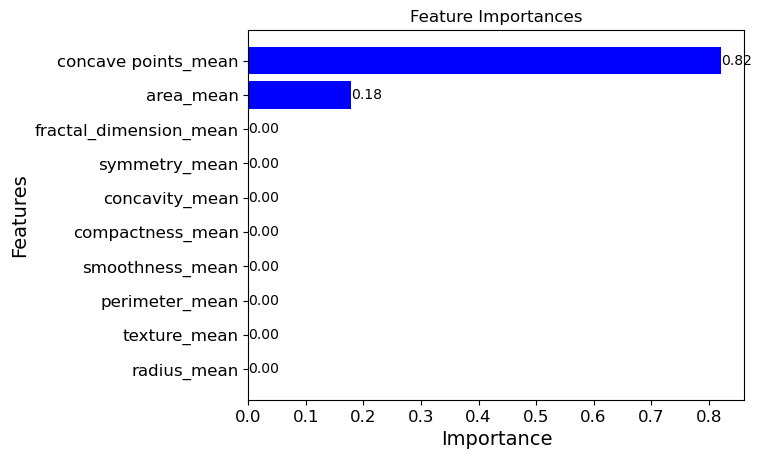

In [17]:
# Get the feature importances from the decision tree classifier
importances = tree.feature_importances_

# Get the indices of the features sorted by importances in descending order
sorted_indices = importances.argsort()[::-1]

# Sort the features and importances accordingly in reversed order
sorted_features = [cn_train_X.columns[i] for i in sorted_indices[::-1]]
sorted_importances = importances[sorted_indices[::-1]]

# Plot the feature importances
fig, ax = plt.subplots()
bars = ax.barh(range(len(sorted_features)), sorted_importances, color='blue')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')

# Add values at the end of each bar
for i, bar in enumerate(bars):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{sorted_importances[i]:.2f}',
            ha='left', va='center', color='black')

plt.show()

Similar to the logistic regression classifier, only two features have feature importances greater than 0. Like the logistic regression classifier, concave points_mean dominate the importance chart, with 0.82 of the importances. However, the secondary feature is different being area_mean with 0.18. 

If some of the feature importances are zero, it means that those features did not contribute to the impurity reduction during the construction of the decision tree. There are a few reasons why this might happen:
- Correlated features: In section 1, we plotted the correlation matrix of the Breast Cancer Wisconsin (diagnostic) dataset and found that there were a large number of features with correlation 0.8 and higher. If there are highly correlated features in the dataset, the decision tree might select one of the correlated features as the most informative and assign zero importance to the others. This happens because the correlated features provide similar information and contribute similarly to impurity reduction.
- Maximum depth or split limitations: If the decision tree is limited in terms of maximum depth or the minimum number of samples required for a split, it might not have enough levels or splits to capture the importance of certain features. Given that the grid search found a max_depth=2, this is highly likely.

## 1.3 Task 3: Principal Component Analysis

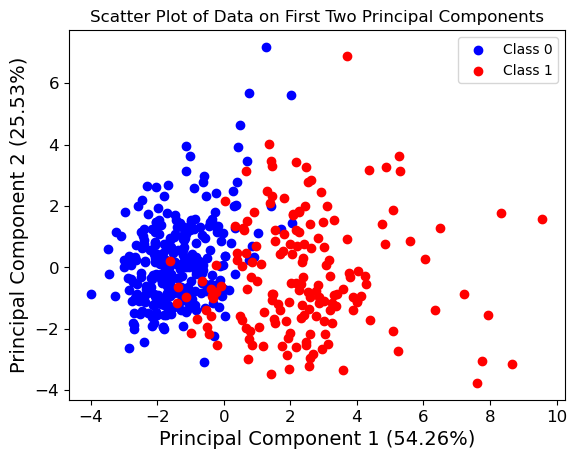

In [18]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cn_train_X)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a scatter plot with different colors for the two classes
plt.scatter(principal_components[cn_train_y == 0, 0], principal_components[cn_train_y == 0, 1], c='blue', label='Class 0')
plt.scatter(principal_components[cn_train_y == 1, 0], principal_components[cn_train_y == 1, 1], c='red', label='Class 1')

plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]*100:.2f}%)')
plt.title('Scatter Plot of Data on First Two Principal Components')
plt.legend()
plt.show()

In [19]:
pca.explained_variance_ratio_

array([0.54258606, 0.25533396])

The plot above shows the scatter plot of the data on the first two principal components. We can observe the following:
- Class Separation: The scatter plot shows that the two classes are linearly seperable in the reduced two-dimensional space. This indicates that the first two principal components capture meaningful information that helps distinguish between the classes.

The explained variance ratio provides insight into the relative importance or contribution of each principal component in capturing the underlying structure of the data. Higher values indicate that the corresponding principal component retains more information about the original dataset.

These values indicate that the first principal component explains approximately 54.29% of the total variance in the dataset, while the second principal component explains approximately 25.90% of the total variance. Together, these two components account for a total of approximately 80.19% of the total variance in the data.

The first principal component captures a significant portion of the variance, indicating that it carries valuable information and potentially separates the classes to a certain extent. The second principal component also contributes to the overall variance, but to a lesser extent compared to the first component.

This analysis is consistent with the feature importance from the decision tree classifier in section 1.2.2 where 2 features dominate the feature importances weightings. 

## 1.4 Task 4&5: Presenting the Biplot

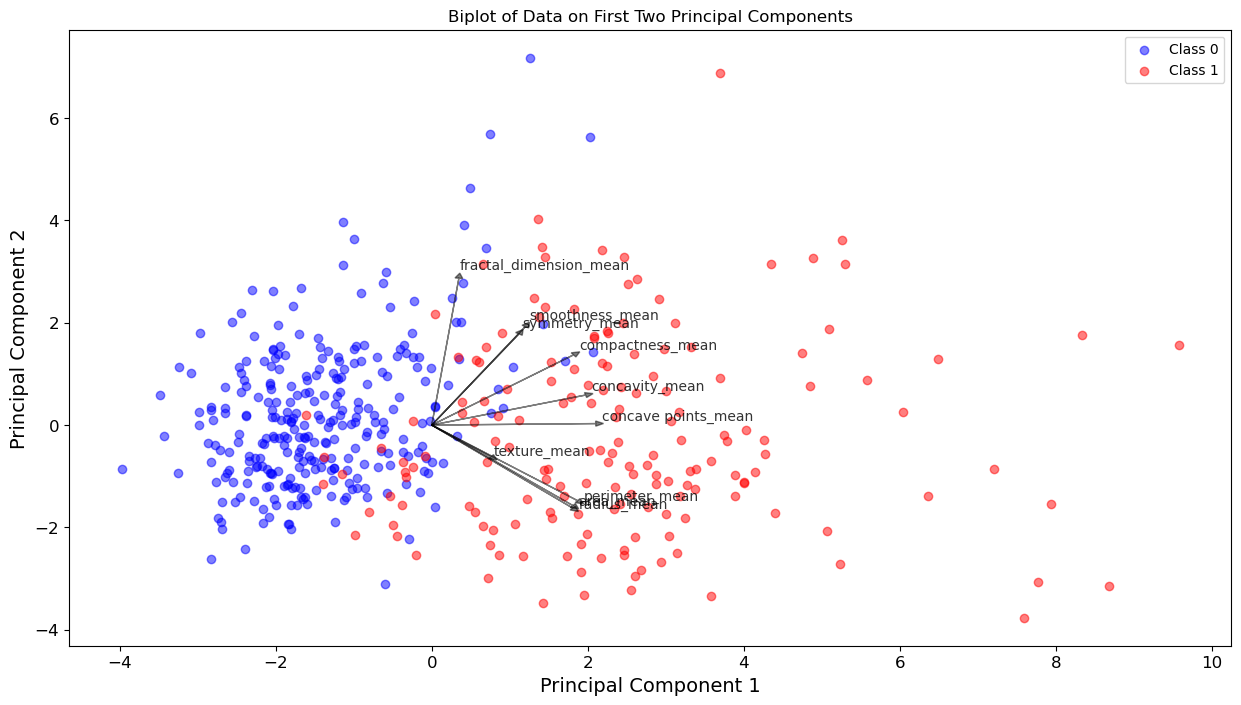

In [20]:
# Get the variable vectors (loadings)
variable_vectors = pca.components_.T

# Create a larger figure with a specific size
fig, ax = plt.subplots(figsize=(15, 8))

# Create a scatter plot of the observed data projected on the first two principal components (with semi-transparent markers)
plt.scatter(principal_components[cn_train_y == 0, 0], principal_components[cn_train_y == 0, 1], c='blue', label='Class 0', alpha=0.5)
plt.scatter(principal_components[cn_train_y == 1, 0], principal_components[cn_train_y == 1, 1], c='red', label='Class 1', alpha=0.5)

# Add variable vectors as arrows with text annotations at the ends
for i, (x, y) in enumerate(variable_vectors):
    plt.arrow(0, 0, x * 5, y * 5, color='black', alpha=0.5, head_width=0.1, head_length=0.1)
    plt.text(x * 5.2, y * 5.2, cn_train_X.columns[i], ha='left', va='bottom', alpha=0.8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Biplot of Data on First Two Principal Components')
plt.legend()
plt.show()

The plot above shows the biplot of the data on the first two principal components. As we saw in section 1.3 the horizontal axis represents the first principal component (PC1), which captures the most significant variation in the data. The vertical axis represents the second principal component (PC2), which captures the second most significant variation orthogonal to PC1.

- The features are represented as arrows in the plot
- The direction and length of the arrows indicate the contribution of each variable to the principal components.
- Variables pointing in the same direction are positively correlated, while those pointing in opposite directions are negatively correlated.
- Longer arrows represent variables with a stronger influence on the principal components.

---

**Interpreting the plot**:
- At the bottom of the plot, there's a large cluster of highly correlated features such as `area_mean`, `perimeter_mean` and `radius_mean`. This is similar to the data we got from the correlation matrix plotted in section 1. However, despite the high correlation, the features arrows are still long which signifies that it has a strong influence on the principal components.
- In the middle of the plot, we have a long arrow for `concave_points_mean` which is parallel to the axis of principal component 1. This suggests that it is very important to this principal component and holds alot of the variance. This is supproted by the feature importance plots in section 1.2.1 and 1.2.2.
- The other features are all pointing in the same general direction which suggests a certain degree of correlation
- `Fractal_dimension_mean` is vertical along the decision boundary. This suggests that it is not contributing much to the decision boundary between the two features. This is also supported by this feature having a weight of 0 in the logistic regression feature importances in section 1.2.1

## 1.6 Task 6: Use PCA to retain 95% of the explained variance

In [21]:
# Perform PCA
pca = PCA()
pca.fit(cn_train_X)

# Calculate cumulative explained variance ratio
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components for 95% explained variance
n_components = np.argmax(cumsum >= 0.95) + 1

print(f"Number of components for 95% explained variance: {n_components}")

pca = PCA(n_components=0.95)
cn_train_X_red = pca.fit_transform(cn_train_X)
cn_test_X_red = pca.transform(cn_test_X)

Number of components for 95% explained variance: 5


In [22]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 5, 7, 9],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [None, 'sqrt', 'log2'],
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid, cv=3, scoring='recall') 

# Train the models
grid_search.fit(cn_train_X_red, cn_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2}
Best cross-validation score: 0.8993316624895572


After performing PCA, we determine that 5 components will be needed to retain 95% of the explained variance. 

As stated in Section 1.1.3, we prefer the decision tree model due to it's higher recall given the nature of our dataset. Therefore, it will be our model of choice for this reduced dimensional dataset. The grid search is run again to determine the optimal hyperparameters given the reduced dataset.

- criterion: gini
- max_depth: None
- min_samples_split: 2
- min_samples_leaf: 3
- max_features: Sqrt

In [23]:
tree_red = DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=3, min_samples_split=2, random_state=123)
tree_red.fit(cn_train_X_red, cn_train_y)
y_pred_tree_red = tree_red.predict(cn_test_X_red)

print(classification_report(cn_test_y, y_pred_tree_red))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95        71
         1.0       0.91      0.93      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



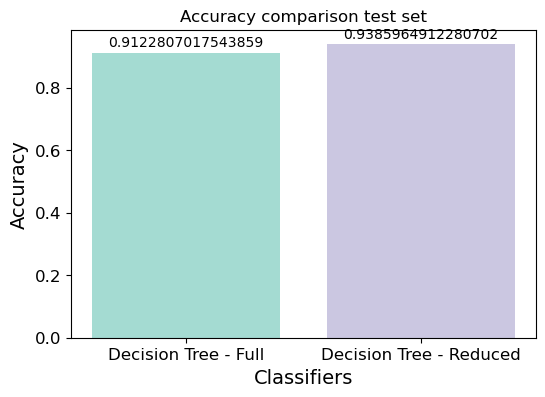

In [24]:
plot_accuracy(y_pred_tree, y_pred_tree_red, 'Decision Tree - Full', 'Decision Tree - Reduced', 'test')

After using PCA to reduce the dimension of the dataset to 5 features, we note that accuracy has increased from 0.91 to 0.94. This could be due to us keeping mose of the explained variance, which preserves the most important information for classification while reducing noise from highly correlated features and features that did not contribute much to the classification. This improved the model's ability to generalize and make accurate preductions. However, it's important to note that accuracy alone may not be the most reliable metric for evaluating the performance of a classifier, especially in this imbalanced dataset.

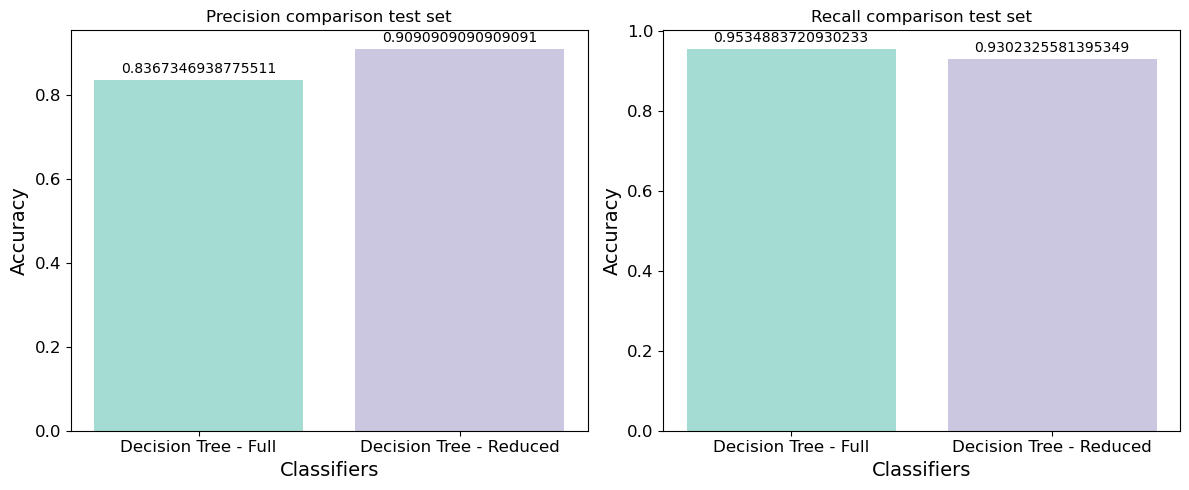

In [25]:
plot_precision_recall(y_pred_tree, y_pred_tree_red, 'Decision Tree - Full', 'Decision Tree - Reduced', 'test')

**Precision**:
- Precision improved in the reduced dataset when compared to the full featured datset
- Retaining important variance in the data can help identify and emphasize the patterns associated with the positive class, leading to a higher precision.
- Removing irrelevant features or reducing noise through PCA may help improve precision by reducing false positives.

**Recall*:
- Precision went down in the reduced dataset when compared to the full featured datset
- By reducing the dimensionality of the data, you might be discarding some information that was relevant for predicting positive instances, resulting in a lower recall.
- PCA aims to capture the most significant variance, but it may not preserve all the details related to the minority class, leading to a decrease in recall. This is especially relevant to our cancer dataset where the positive class is the minority. 

---

**Trade-off**:
- By reducing the dimensionality of the datset, we lower the cost of training the model
    - With fewer features, the model requires less memory to store and process the data
    - This reduction in feature space can result in computational cost savings
    - With a reduced dataset after PCA, training a model can be faster since there are fewer dimensions to consider during optimization.
    - Making predictions on the reduced dataset requires less computational effort.
    
- We want higher recall when predicting malignant tumors
    - As mentioned in previous sections, we want a classifier with as high a recall as possible. A high recall value indicates that the model is correctly identifying a large proportion of the positive instances. In terms of the cancer dataset, a true positive would mean a malignant tumor while a false negative would mean a malignant tumor that was falsely classified as benign.
    - We need to consider the cost / performace trade-off when deciding if the cost benefits is worth potential death due to a misdiagnosis

# 2. A clustering analysis on airlines safety records

In [26]:
# Load the dataset
airline = pd.read_csv('airline-safety.csv')

In [27]:
airline.head()

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0


In [28]:
# Remove the airline column
airlines = airline['airline']
airline = airline.drop('airline', axis=1)

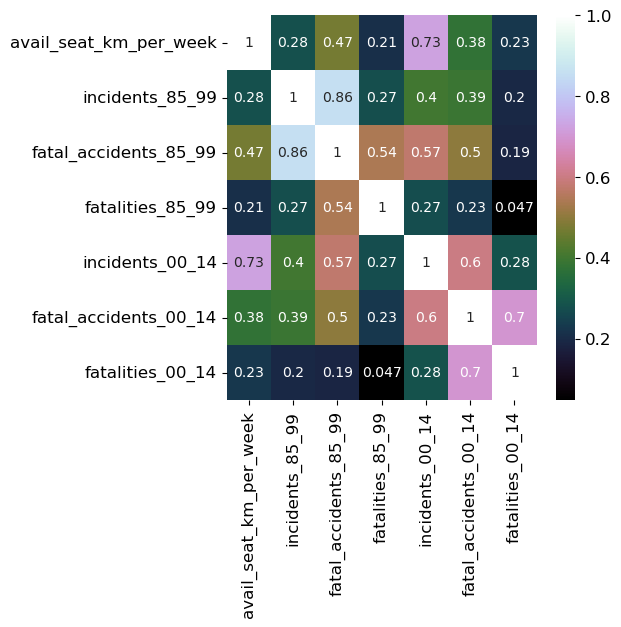

In [29]:
plt.figure(figsize=(5, 5))
sns.heatmap(airline.corr(), cmap='cubehelix', annot=True)
plt.show()

## 2.1 Task 1: Plotting Silhouette Score

- Plot elbow
    - look for turning point
- Plot sillhouette score
    - look for highest
- Plot knife thing
    - are they too far from threshold?

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import warnings

def plot_elbow_silhouette(airline_data, dataset_name):
    kmeans_per_k = [KMeans(n_clusters=k, random_state=5508, n_init=10).fit(airline_data)
                for k in range(2, 9)]

    inertias = [model.inertia_ for model in kmeans_per_k]
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    
    # Plot for elbow diagram
    axs[0].plot(range(2, 9), inertias, "bo-")
    axs[0].set_xlabel("$k$")
    axs[0].set_ylabel("Inertia")
    axs[0].set_title('Inertia for ' + dataset_name)
    axs[0].grid()
    
    
    silhouette_scores = [silhouette_score(airline_data, model.labels_)
                         for model in kmeans_per_k]
    
    # Plot for silhouette score
    axs[1].plot(range(2, 9), silhouette_scores, "bo-")
    axs[1].set_xlabel("$k$")
    axs[1].set_ylabel("Silhouette score")
    axs[1].set_title('Silhouette score for ' + dataset_name)
    axs[1].grid()
    
    # Adjust spacing between subplots
    plt.tight_layout()

    
    plt.show()
    
    return kmeans_per_k, silhouette_scores

In [31]:
from matplotlib.ticker import FixedLocator, FixedFormatter

def plot_silhouette_diagram(airline_data, kmeans_per_k, silhouette_scores):
    plt.figure(figsize=(11, 18))

    for k in range(2, 9):
        plt.subplot(4, 2, k - 1)

        y_pred = kmeans_per_k[k - 2].labels_
        silhouette_coefficients = silhouette_samples(airline_data, y_pred)

        padding = len(X) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = plt.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
        if k in (2, 4, 6, 8):
            plt.ylabel("Cluster")

        if k in (7, 8):
            plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
        else:
            plt.tick_params(labelbottom=False)

        plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
        plt.title(f"$k={k}$")

    plt.show()

## 2.1.1 Silhouette Score with full dataset

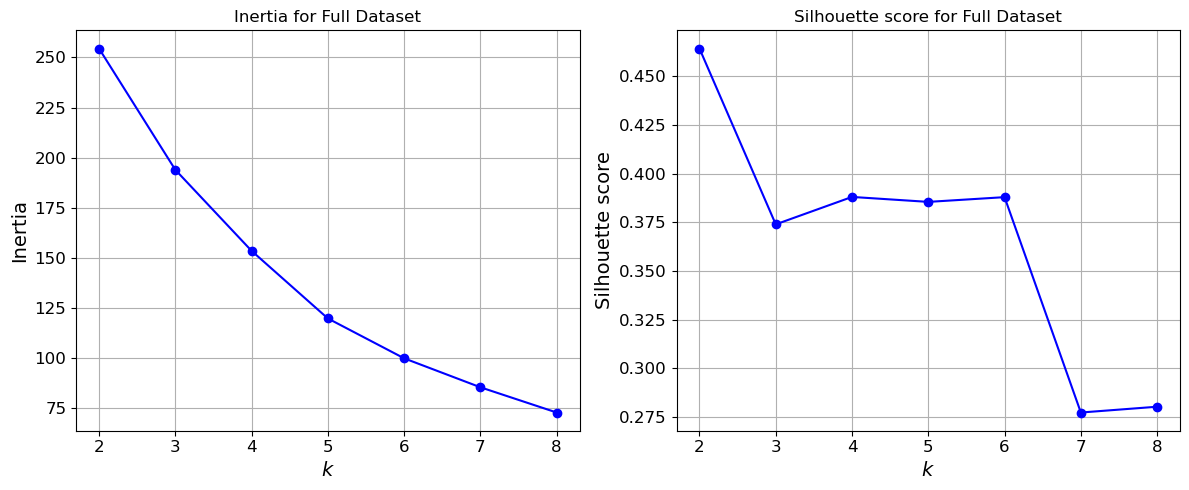

In [32]:
from sklearn.preprocessing import MinMaxScaler

airline_full = airline.copy()

scaler = StandardScaler()
airline_scaled = scaler.fit_transform(airline_full)

kmeans_scaled, silhouette_scaled = plot_elbow_silhouette(airline_scaled, 'Full Dataset')

The plots above was produced with a scaled version of the entire dataset. The data has to be scaled in this instance due to the presence of the `avail_seat_km` feature which is 9 orders of magnitude above the other features. This can seriously impact the clustering process. In k-means clustering, the algorithm aims to partition a given dataset into k clusters based on the similarity of data points. The similarity is typically measured using the Euclidean distance between feature vectors. Each feature contributes equally to the calculation of distances. As a result, features with larger scales can dominate the distance calculation and cluster assignments and have to be scaled.

---

**Inertia**

Inertia is the sum of the squared distances between the instances and their closest centroid. A lower inertia is better. However, inertia is not a good performance metric when trying to choose k because it keeps getting lower as we k increases. Instead, we plot the inertia for all values of k and find an inflection point called the elbow. This point is where the inertia drops much slower after this elbow point. Upon examining this plot, we find that the elbow would be where k=5.

---

**Silhouette Score**

A more precise way of chooseing the best value of clusters is the silhouette score. The silhouette score, is the mean silhouette coefficient over all the instances, it is computed using the formula: (b – a) / max(a, b) Where a is the mean distance to the other instances in the same cluster.

A silhouette score that approaches 1 means that the instance is well seperated and far from any neighbouring clusters. A silhouette score that approaches 0 means that the cluster is close to a boundary. 

While k=2 has the highest silhouette score, we will discount it due to the excessive inertia, so we will pick the next highest. However, this is still not very conclusive as the silhouette scores from k=3 to k=6 are roughly in the same ballpark. Further refinement is needed before we pick our value of k. This can be done through plotting the silhouette diagram. 

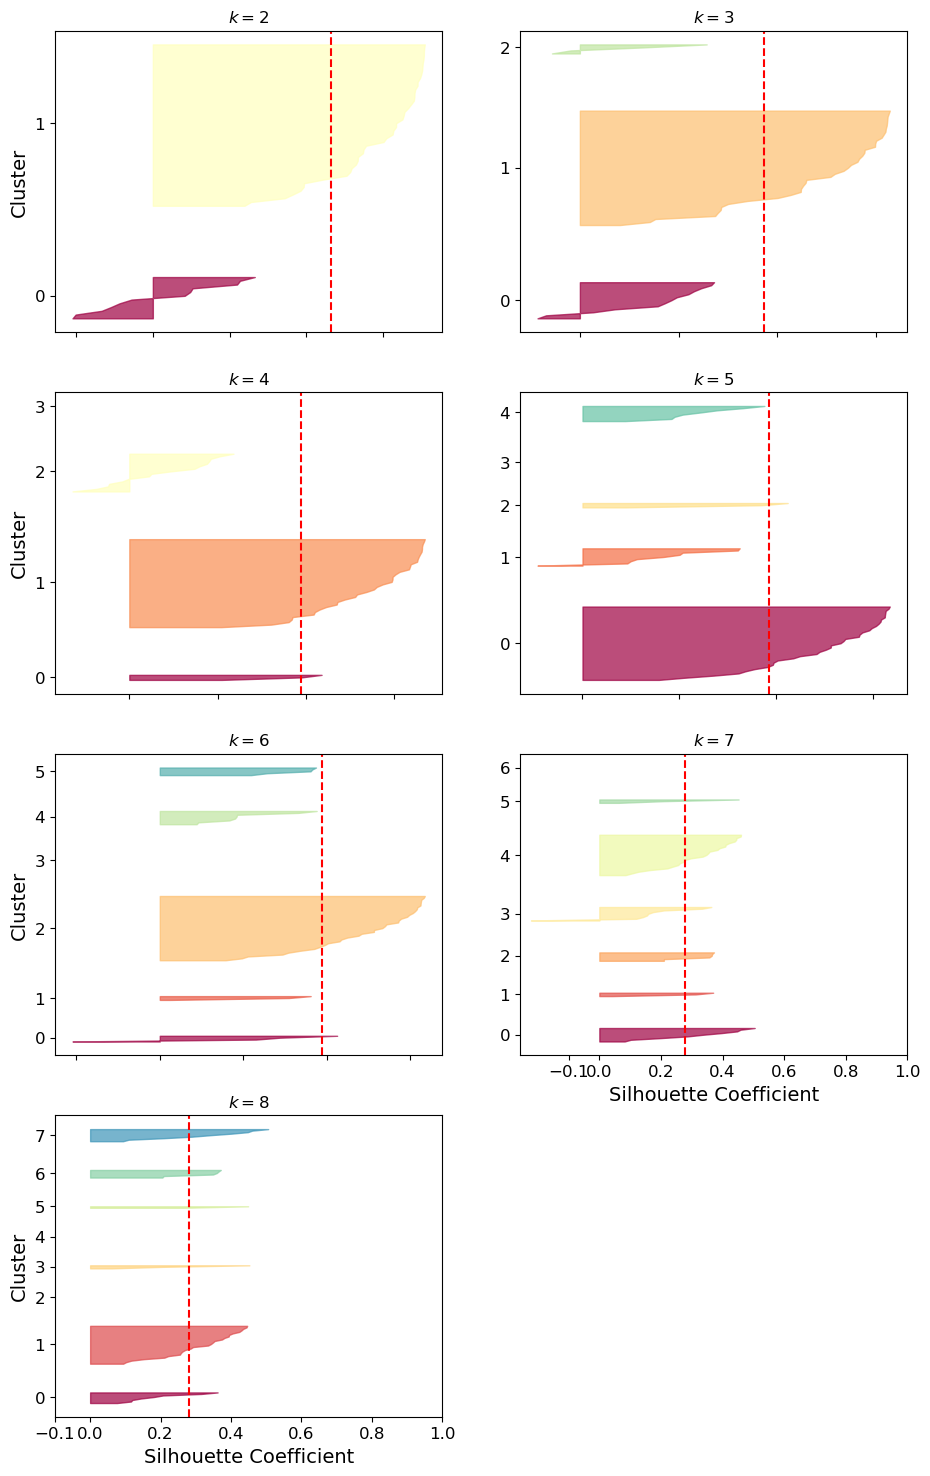

In [33]:
plot_silhouette_diagram(airline_scaled, kmeans_scaled, silhouette_scaled)

The plot depicted above illustrates a silhouette diagram for each cluster. Each cluster is represented by a knife-shaped figure within the diagram. The height of the figure corresponds to the number of instances present in the cluster, while the width signifies the sorted silhouette coefficients of the instances within the cluster. A wider shape indicates a more favorable arrangement of the instances, suggesting better clustering performance.

The vertical dashed lines in the plot indicate the mean silhouette score for each specific number of clusters. These lines serve as reference points to assess the quality of each cluster. If many instances fall to the left of the dashed line), it suggests that the cluster is suboptimal. Based on this we can immediately eliminate k=2,3,4,5,6.

This leaves us with k=7 and k=8. However, both are not optimal due to the extremely low silhouette score they received in the previous step.

Due to unsatifactory results, we will try removing the feature `avail_seat_km` and try again.

## 2.1.2 Silhouette Score with reduced dataset

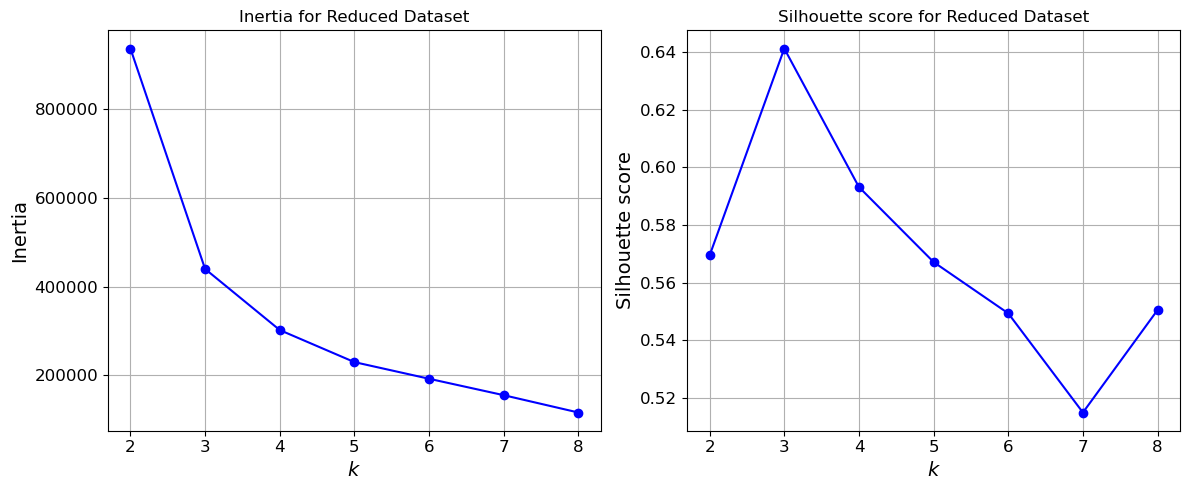

In [34]:
airline_reduced = airline.drop('avail_seat_km_per_week', axis=1)

kmeans_reduced, silhouette_reduced = plot_elbow_silhouette(airline_reduced, 'Reduced Dataset')

The plots above was produced with the dataset after `avail_seat_km` was dropped. Due to the remaining features being on the same scale, we do not need to scale the data.

---

**Inertia**

When trying to find the elbow on the inertia plot, k=4 stands out as the point of inflection on the graph. Any lower value would have too high of an inertia and any lower value would be too much.

---

**Silhouette Score**

From examining the plot of the silhouette score for the reduced dataset, k=3 is the obvious choice. It has the highest score of 0.64 and performs significantly better than the other values of k.

---

In order to decide between the two values of k, we will have to examine the silhouette diagrams.


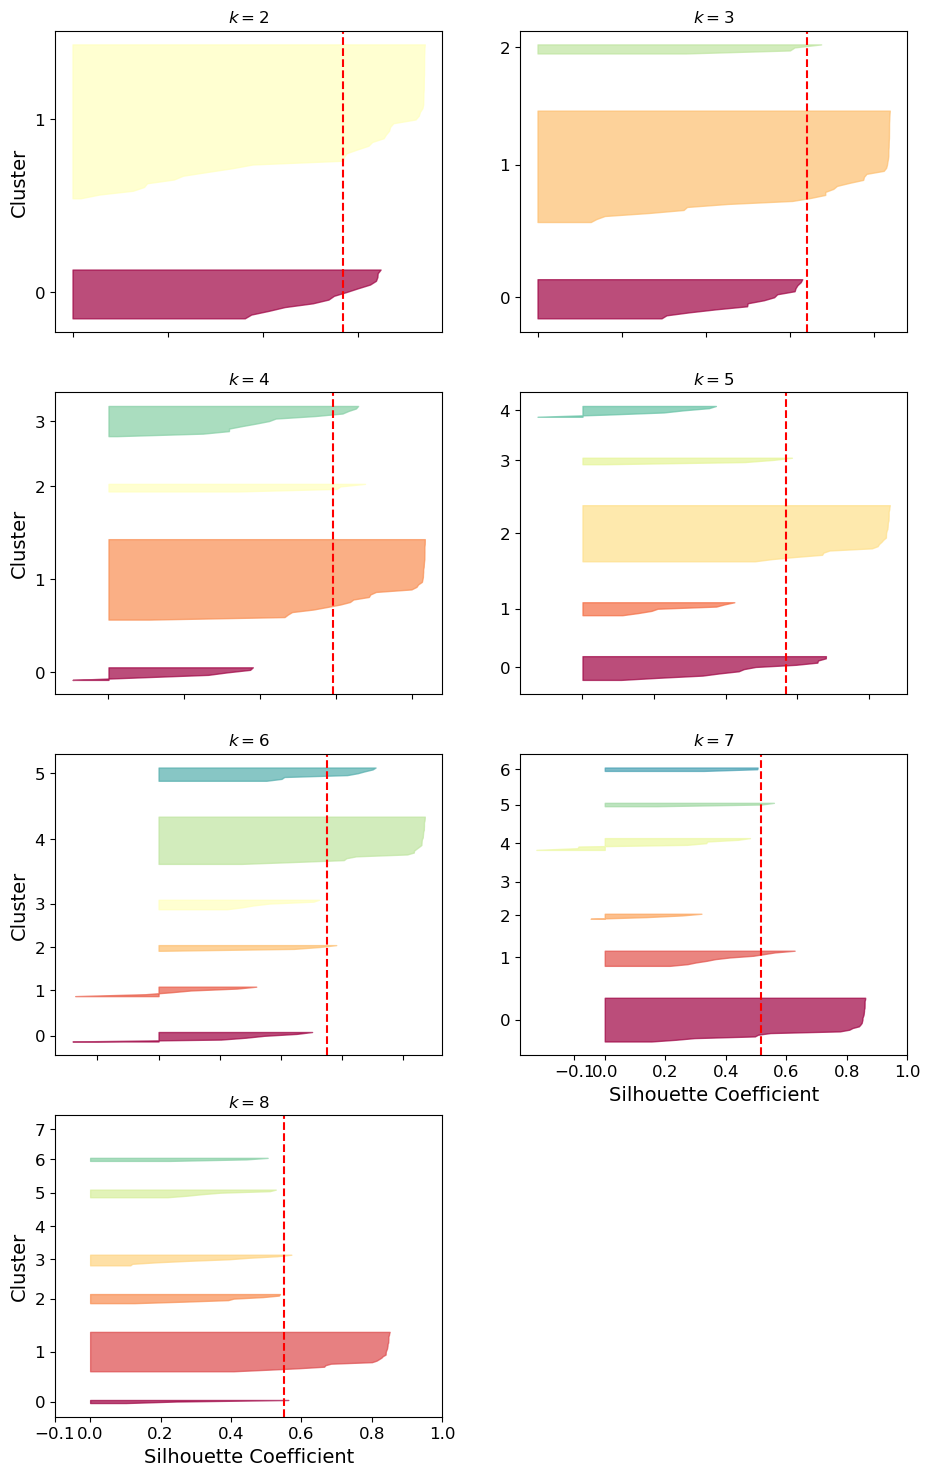

In [35]:
plot_silhouette_diagram(airline_reduced, kmeans_reduced, silhouette_reduced)

Upon examining the silhouette diagrams, we can confidently eliminate k=4 for the following reasons:
- One of the clusters is very far from the silhouette score threshold
- For the same cluster, some of the silhouette coefficients are negative. You can see this as the tail end of the knife is past the 0 mark. A negative silhouette coefficient indicates that the data point is likely assigned to the wrong cluster. This suggests that the clustering algorithm has not performed well for that data point. We want to find clusters without negative coefficients.

Based on this information, we confidently choose k=3.

### 2.1.3 Scaled Reduced Dataset

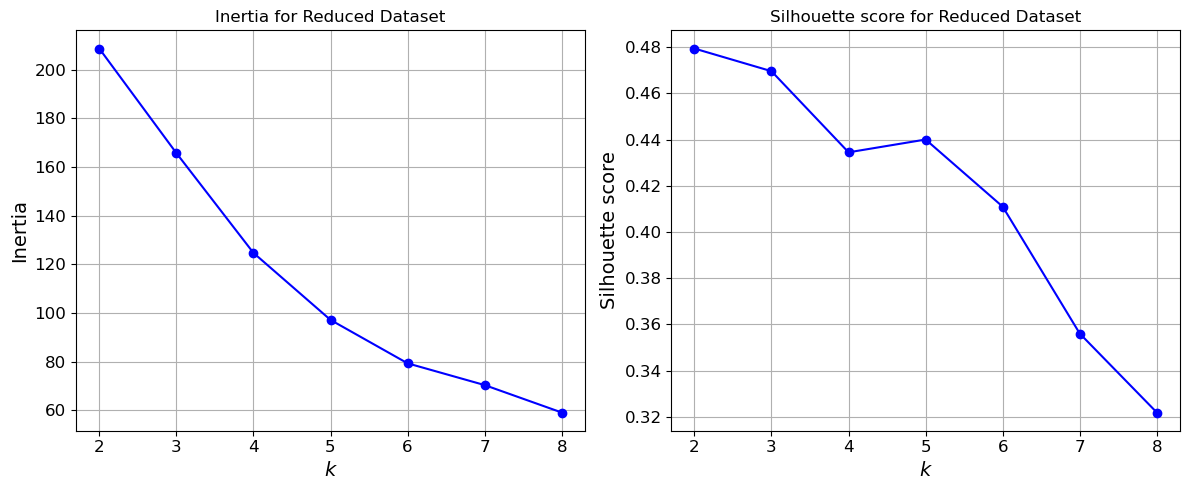

In [36]:
airline_reduced_scaled = airline.drop('avail_seat_km_per_week', axis=1)

scaler = StandardScaler()
airline_reduced_scaled = scaler.fit_transform(airline_reduced_scaled)

kmeans_reduced_scaled, silhouette_reduced_scaled = plot_elbow_silhouette(airline_reduced_scaled, 'Reduced Dataset')

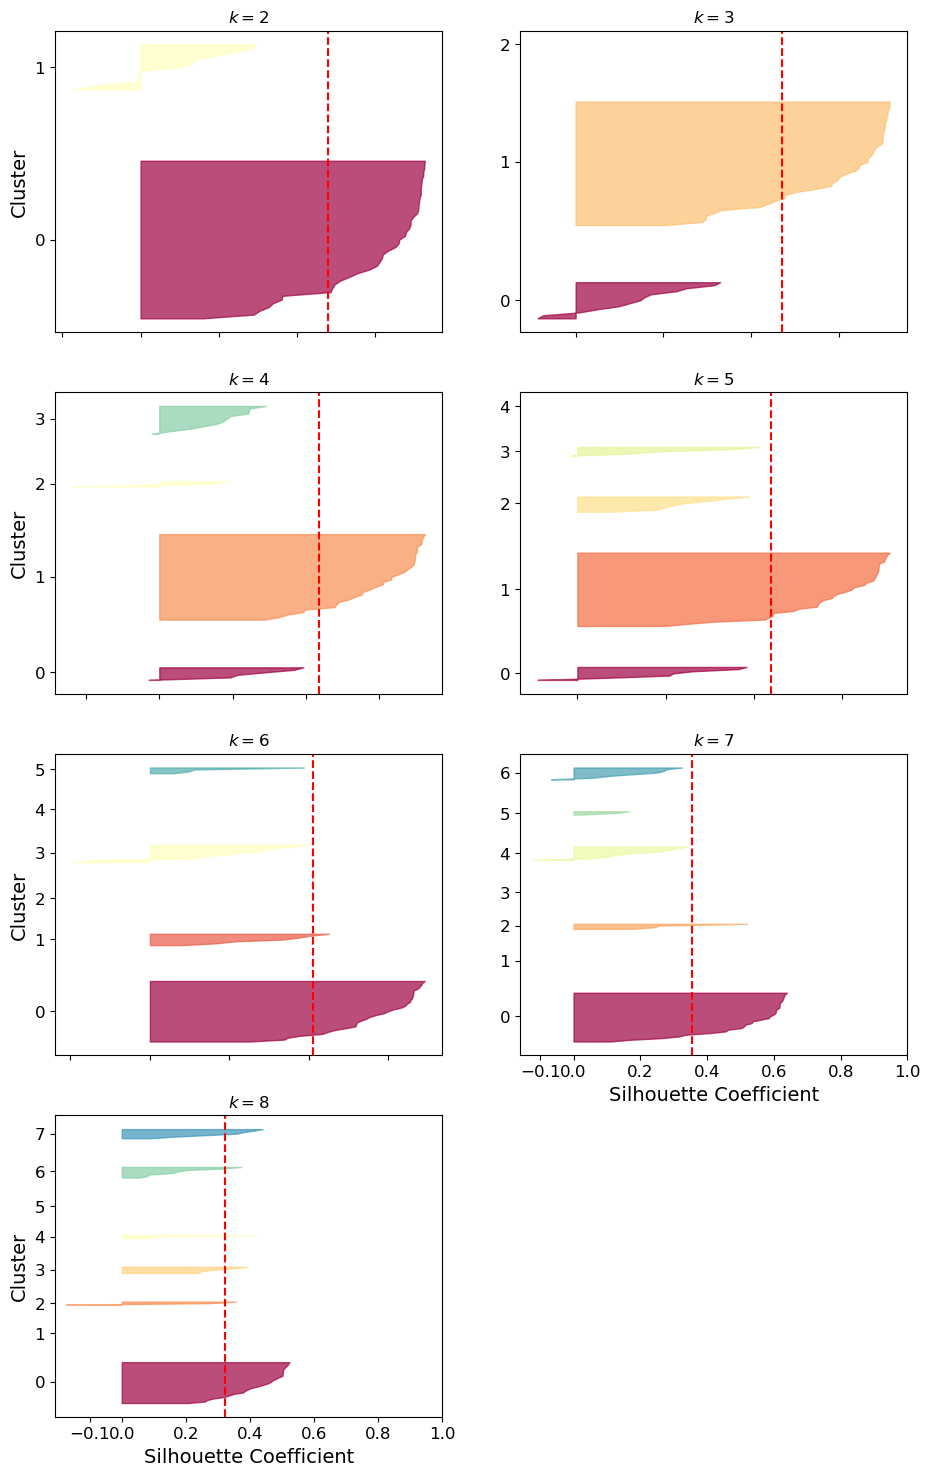

In [37]:
plot_silhouette_diagram(airline_reduced_scaled, kmeans_reduced_scaled, silhouette_reduced_scaled)

The results of this section will be discussed in section 2.3

## 2.2 Task 2: Apply K-means clustering

In [38]:
def perform_k_means(airline_dataset):

    # Apply K-means Clustering
    kmeans = KMeans(n_clusters=3, random_state=5508, n_init=10)
    kmeans.fit(airline_dataset)

    # Interpret the Results
    cluster_labels = kmeans.labels_

    # Calculate the mean values of features for each cluster
    cluster_means = pd.DataFrame(kmeans.cluster_centers_, columns=airline_dataset.columns)
    cluster_means.index = ['Cluster 1', 'Cluster 2', 'Cluster 3']

    # Count the number of airlines in each cluster
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()


    # Visualize the Clusters
    cluster_labels = kmeans.labels_

    # Add cluster labels to the preprocessed data
    airline_dataset['Cluster'] = cluster_labels
    airline_dataset['Cluster'] = airline_dataset['Cluster'].add(1)

    # Visualize each feature against each other feature
    sns.set(style="ticks")
    sns.pairplot(airline_dataset, hue="Cluster")
    
    
    plt.show()
    
    cluster1 = airlines[airline_dataset['Cluster'] == 1]
    cluster2 = airlines[airline_dataset['Cluster'] == 2]
    cluster3 = airlines[airline_dataset['Cluster'] == 3]
    
    # Print the cluster means
    print("Cluster Means:")
    print(cluster_means)
    
    print("\nCluster Counts:")
    print(cluster_counts)
    
    print('\nCluster 1:')
    print(', '.join(cluster1))
    
    print('\nCluster 2:')
    print(', '.join(cluster2))
    
    print('\nCluster 3:')
    print(', '.join(cluster3))

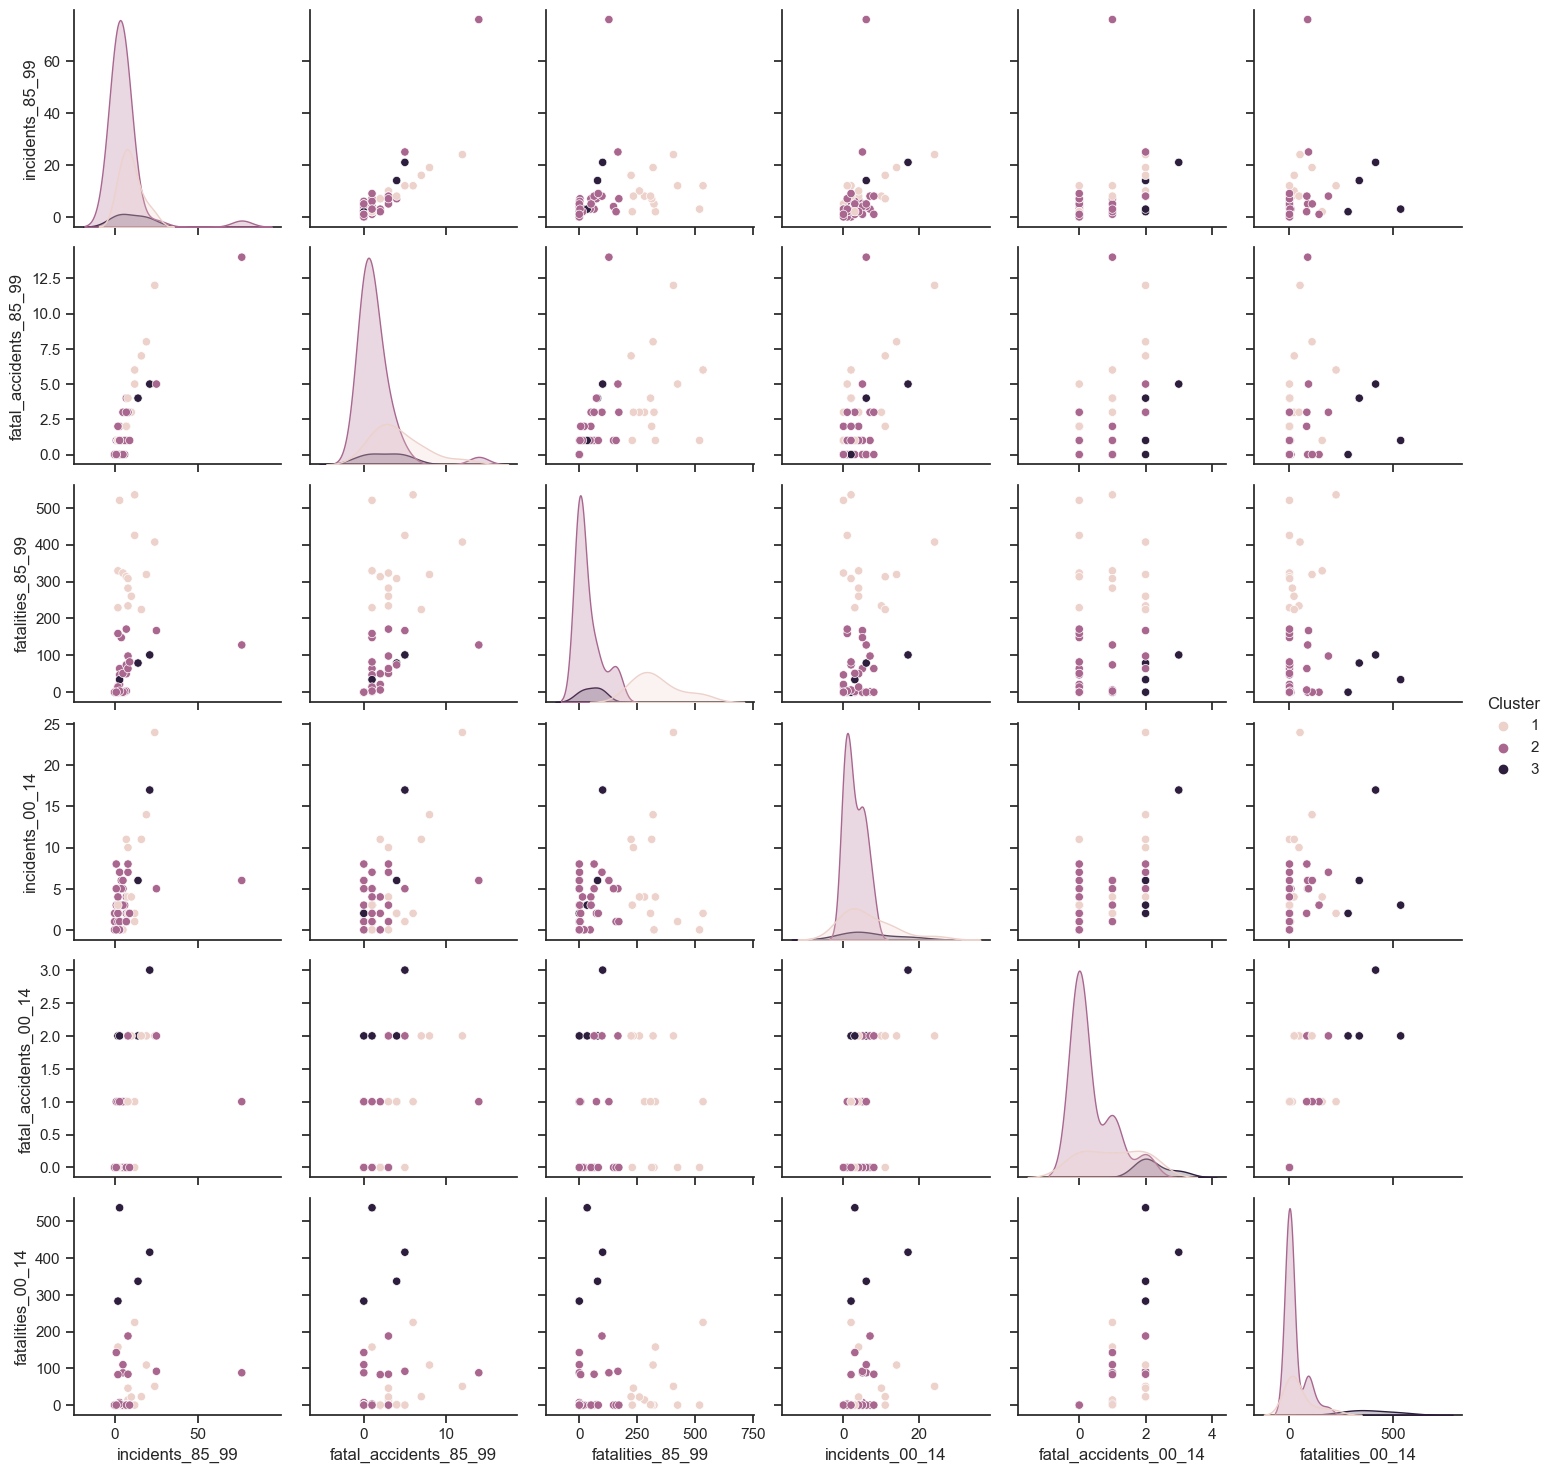

Cluster Means:
           incidents_85_99  fatal_accidents_85_99  fatalities_85_99  \
Cluster 1         9.714286               4.214286        336.285714   
Cluster 2         5.947368               1.394737         36.131579   
Cluster 3        10.000000               2.500000         53.500000   

           incidents_00_14  fatal_accidents_00_14  fatalities_00_14  
Cluster 1         6.428571               1.000000         46.357143  
Cluster 2         2.973684               0.368421         23.342105  
Cluster 3         7.000000               2.250000        393.250000  

Cluster Counts:
0    14
1    38
2     4
dtype: int64

Cluster 1:
Air India*, Avianca, China Airlines, Delta / Northwest*, Egyptair, Garuda Indonesia, Japan Airlines, Korean Air, Pakistan International, Saudi Arabian, SWISS*, Thai Airways, United / Continental*, US Airways / America West*

Cluster 2:
Aer Lingus, Aeroflot*, Aerolineas Argentinas, Aeromexico*, Air Canada, Air New Zealand*, Alaska Airlines*, Alitalia, A

In [39]:
perform_k_means(airline_reduced)

The pair plot above shows the clusters for each of the features plotted against all other features. When examining this pariplot, some common trends come to light.
- For a significant number of the plots the points from cluster 1 and cluster 2 overlap significantly
    - Some examples: `incidents_85_99 vs fatalities_00_14` and `incidents_85_99 vs incidents_00_14`
    - We will treat these overlapping points as errors as they provide inconclusive data. We want well seperated and defined clusters. These overlapping points show that these features together are not providing a good clustering. 
    - The only way to solve this would be to gather more data points in a larger dataset
    
- `fatalities_85_99` proved to be a very good discriminator. Almost all the plots with this feature in it are very well seperated.
    
- Cluster 3 contains very few points but they are very well seperated in the majority of the pairplots

---

Examining the cluster means gives us more insight into how the clustering was performed:

- The main discriminator for cluster 1 seems to be `fatalities_85_99` as it has a mean 6 times greater than the next closest cluster
    - This cluster is relatively large and contains airlines that had a high number of fatal incidents in the years 1985-1999
- Cluster 2 seems to have the lowest means for each feature across the board.
    - This is the largest cluster by far and contains airlines that had low incidents and fatalities across the entire range of years from 1985 to 2014
- The main discriminator for cluster 3 is `fatalities_00_14`. Similar to cluster1, this cluster mean is significantly higher than the other cluster means.
    - This group is the smallest group and mainly consists of airlines that have a high number of incidents in the entire range from 1985 to 2014
    - While the airlines in this category did not have high fatalities `fatalities_85_99`, airlines in this cluster registered the highest average total incidents from 1985-1999 and 2000-2014
    - It seems that the safety of these airlines went down over time as the number of incidents stayed the same but fatal incidents went up

## 2.3 Task 3: Explain Decisions on scaling and feature selection

**Feature Selection**

In section 2, we covered feature selection where we decided to drop `avail_seat_km`. Section 2.1.2 showed the inertia plot, silhouette score and silhouette diagram for the entire dataset. In this instance, we had no option but to scale the dataset due to the difference of 9 orders of magnitude for the `avail_seat_km` feature. However, both the inertia plot and the silhouette score proved insufficient to select a value of k as they provided different answers. When we moved on to the silhouette diagram, we found that the values of k recommended by the diagrams were again in conflict with the silhouette score. From this we concluded that the feature `avail_seat_km` was not a good feature to include in the clustering.

Once we removed the feature, the inertia plot as well as the silhouette score were able to give us a definitive answer that the value of k should be 3. We examined the silhouette diagram and that confirmed the answer. 

---

**Scaling**

A decision was made to not scale the data. Section 2.1.3 was attempted by scaling the dataset after `avail_seat_km` was dropped. It can be seen from the silhouette score that both k=2 and k=3 are the most viable options. However, upon examining the silhouette diagram, it can be observed that the knife plot for the clusters for both k=2 and k=3 do not meet the threshold of the silhouette score. Some negative values were also observed, an as discussed in section 2.1.1, we do not want negative values in the knife plot. Therefore, a decision was made not to scale the data that was used in section 2.2.

## 2.4 Task 4: Feature selection by years

### 2.4.1 Features from 1985-1999

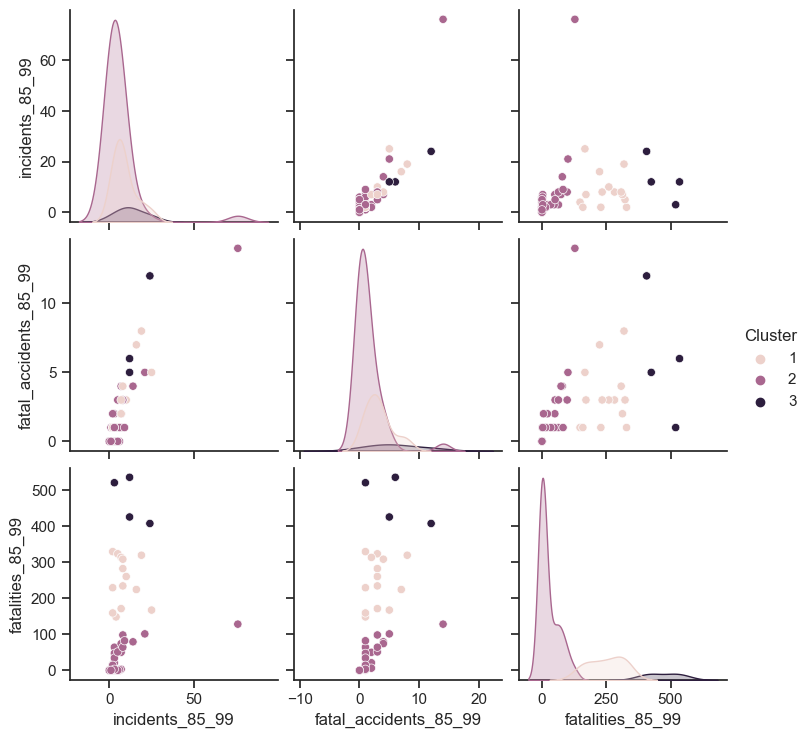

Cluster Means:
           incidents_85_99  fatal_accidents_85_99  fatalities_85_99   Cluster
Cluster 1         8.785714               3.214286        247.571429  1.285714
Cluster 2         6.000000               1.394737         24.789474  2.105263
Cluster 3        12.750000               6.000000        471.750000  1.000000

Cluster Counts:
0    14
1    38
2     4
dtype: int64

Cluster 1:
Air India*, Avianca, Egyptair, Ethiopian Airlines, Garuda Indonesia, Iberia, Pakistan International, Saudi Arabian, South African, SWISS*, Thai Airways, United / Continental*, US Airways / America West*, Vietnam Airlines

Cluster 2:
Aer Lingus, Aeroflot*, Aerolineas Argentinas, Aeromexico*, Air Canada, Air France, Air New Zealand*, Alaska Airlines*, Alitalia, All Nippon Airways, American*, Austrian Airlines, British Airways*, Cathay Pacific*, Condor, COPA, El Al, Finnair, Gulf Air, Hawaiian Airlines, Kenya Airways, KLM*, LAN Airlines, Lufthansa*, Malaysia Airlines, Philippine Airlines, Qantas*, Royal

In [40]:
airline_95_99 = airline_reduced.drop(['incidents_00_14', 'fatalities_00_14', 'fatal_accidents_00_14'], axis=1)
perform_k_means(airline_95_99)

**Pairplot**

- Immediately, we can see that the clusters in this pairplot are much better seperated than the clusters in section 2.2. Three distince clusters can be seen in every pariplot with the exception of `fatal_accidents_85_99 vs incidents_85_99`. 
    - This suggests that the features from 1985-1999 exhibit distinct patterns or differences among the data points. This indicates that the chosen features contain valuable information for discriminating between different groups or categories within the dataset.
    - The presence of well-separated clusters could imply that the data itself naturally forms distinct groups or clusters based on the given features. 
- Considering the nature of the data that we are inputting, this is likely to be the case.
    - This allows us to split airlines into low, medium and high accident rates in the years 1985-1999. This could explain the natural clusters that form.

---

**Cluster Means**

-  Examining the cluster means supports the conclusion from the pairplot
    - Cluster 2: Has the lowest incidents, fatal accidents and fatalities in the time period
    - Cluster 1: Has three times the number of fatal accidents when compared to cluster 2 and 10 times the fatalities
    - Cluster 3: Has twice the number of fatal accidents when compared to cluster 1 and twice the fatalities

- The way the clusters are determined have also changed as the algorithm is no longer trying to draw links between the data from 1985-1999 and 2000-2014. 

---

Sorting the data by the year they were captured has vastly improved the performance of the k means algorithm. 

## 2.4.2 Features from 2000-2014

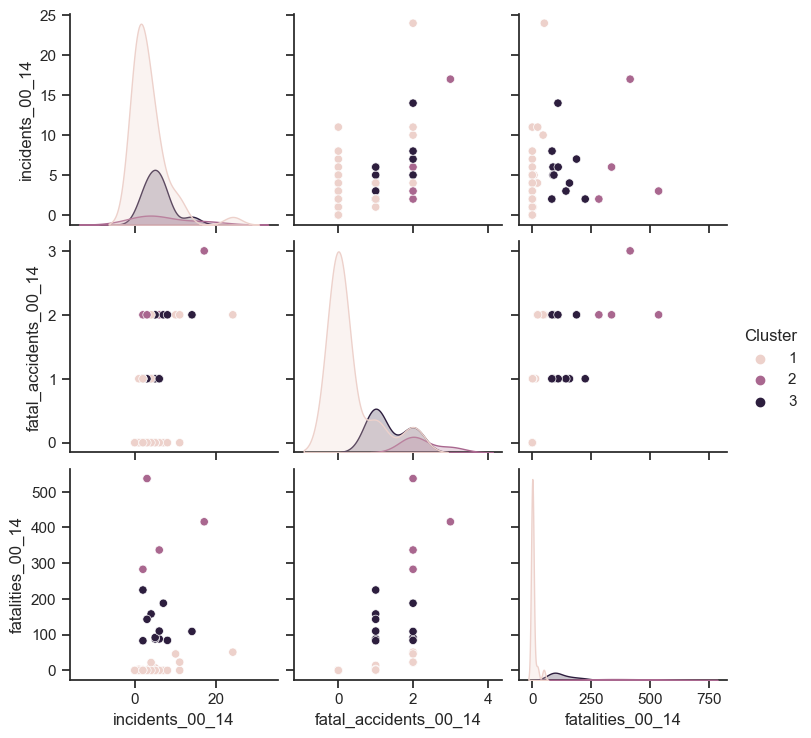

Cluster Means:
           incidents_00_14  fatal_accidents_00_14  fatalities_00_14   Cluster
Cluster 1         3.439024               0.317073          4.097561  1.731707
Cluster 2         7.000000               2.250000        393.250000  3.000000
Cluster 3         5.636364               1.363636        124.363636  1.727273

Cluster Counts:
0    41
1     4
2    11
dtype: int64

Cluster 1:
Aer Lingus, Aerolineas Argentinas, Aeromexico*, Air Canada, Air New Zealand*, Alitalia, All Nippon Airways, Austrian Airlines, Avianca, British Airways*, Cathay Pacific*, Condor, COPA, Delta / Northwest*, Egyptair, El Al, Finnair, Garuda Indonesia, Hawaiian Airlines, Iberia, Japan Airlines, KLM*, Korean Air, LAN Airlines, Lufthansa*, Pakistan International, Philippine Airlines, Qantas*, Royal Air Maroc, Saudi Arabian, South African, Southwest Airlines, Sri Lankan / AirLanka, SWISS*, TACA, TAP - Air Portugal, Thai Airways, US Airways / America West*, Vietnam Airlines, Virgin Atlantic, Xiamen Airlines


In [41]:
airline_00_14 = airline_reduced.drop(['incidents_85_99', 'fatalities_85_99', 'fatal_accidents_85_99'], axis=1)
perform_k_means(airline_00_14)

**Pairplot**

- We can see that the clusters in this pairplot are much better seperated than the clusters in section 2.2. However, the degree of seperation of the clusters are not as good as the ones in section 2.4.1. Despite that, we can see three distince clusters. 
    - The pairplots featuring `incidents_00_14` are not as good as the other ones
    - This suggests that `incidents_00_14` is not a very good discriminator for the different groups within this dataset.
    - We are able to see well defined clusters in the other plots
 

---

**Cluster Means**

-  Examining the cluster means supports the conclusion from the pairplot
    - Cluster 1: Has the lowest incidents. Near 0 fatal accidents and fatalities in the single digits. This cluster is distinctly seperated from the other two clusters.
    - Cluster 3: Has twice the number of incidents when compared to cluster 1 and 100 times the fatalities. 
    - Cluster 2: Has a small number more incidents and fatal accidents when compared to cluster 3 and three times the fatalities. The lack of seperation in the incidents and fatal accidents could be the reason why this cluster is not too distince from cluster 3.

- The way the clusters are determined have also changed as the algorithm is no longer trying to draw links between the data from 1985-1999 and 2000-2014. 

---

Sorting the data by the year they were captured has vastly improved the performance of the k means algorithm. 

## 2.5 Creating new features

### 2.5.1 Adding a small number to every 0 value 

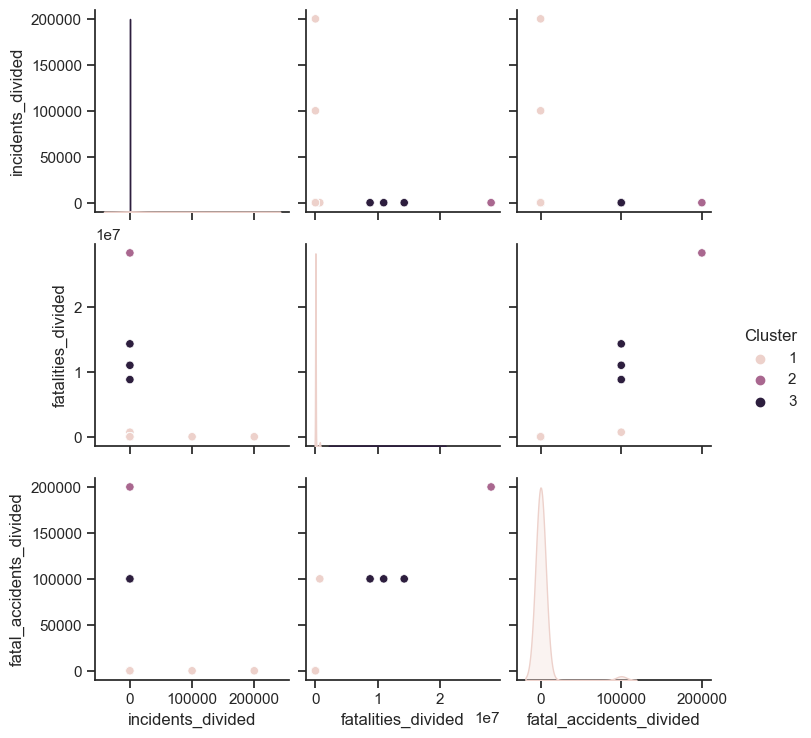

Cluster Means:
           incidents_divided  fatalities_divided  fatal_accidents_divided
Cluster 1        5770.123454        1.346264e+04              1923.508474
Cluster 2           1.000000        2.830000e+07            200000.000000
Cluster 3           1.733333        1.136667e+07            100000.000000

Cluster Counts:
0    52
1     1
2     3
dtype: int64

Cluster 1:
Aer Lingus, Aeroflot*, Aerolineas Argentinas, Aeromexico*, Air Canada, Air France, Air India*, Air New Zealand*, Alitalia, All Nippon Airways, American*, Austrian Airlines, Avianca, British Airways*, Cathay Pacific*, China Airlines, Condor, COPA, Delta / Northwest*, Egyptair, El Al, Ethiopian Airlines, Finnair, Garuda Indonesia, Hawaiian Airlines, Iberia, Japan Airlines, KLM*, Korean Air, LAN Airlines, Lufthansa*, Malaysia Airlines, Pakistan International, Philippine Airlines, Qantas*, Royal Air Maroc, Saudi Arabian, Singapore Airlines, South African, Southwest Airlines, Sri Lankan / AirLanka, SWISS*, TACA, TAM, TAP

In [42]:
airline_small = airline_reduced.copy()

# Add a small number to every 0 value to avoid dividing by 0
airline_small = airline_small.astype(float)
airline_small[airline_small == 0] += 1e-5
airline_small['incidents_divided'] = airline_small['incidents_00_14'] / airline_small['incidents_85_99']
airline_small['fatalities_divided'] = airline_small['fatalities_00_14'] / airline_small['fatalities_85_99']
airline_small['fatal_accidents_divided'] = airline_small['fatal_accidents_00_14'] / airline_small['fatal_accidents_85_99']

airline_small = airline_small[['incidents_divided', 'fatalities_divided', 'fatal_accidents_divided']]
perform_k_means(airline_small)

When the features from 2000-2014 are divided by the respective features from 1985-1999, we encounter a large number of infinity values caused by dividng by 0. In section 2.5.1, we try to tackle this by adding a very small number to each value of 0 to avoid this error. However, when a normal number is divided by a very small number you get a very large number. For example, for the `incidents_divided` features, cluster 1 mean is 5770 while the means for clusters 2 and 3 are 1 and 1.7 respectively. It is determined that this is not a good strategy.

### 2.5.2 Setting every 0 value to 1

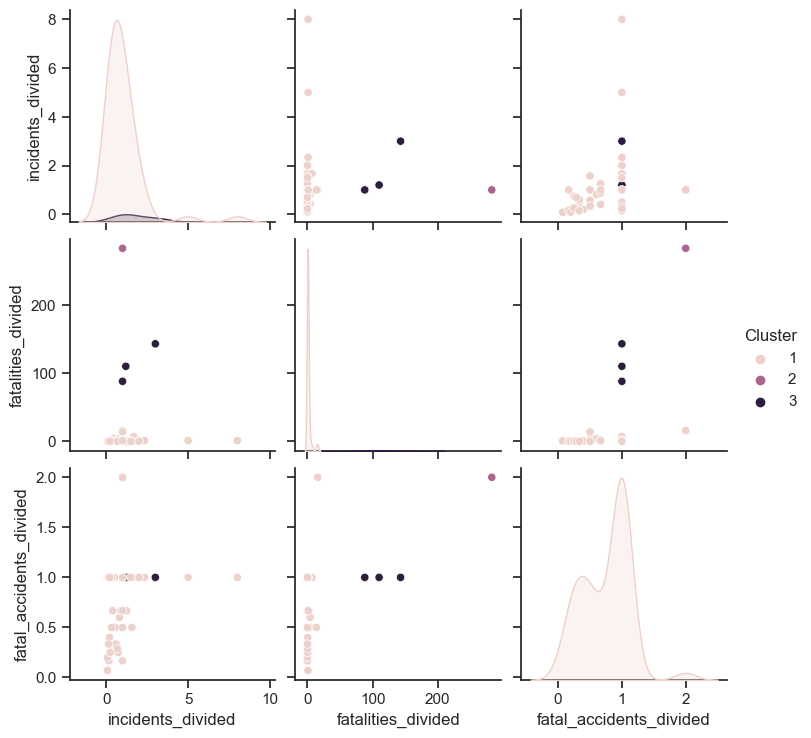

Cluster Means:
           incidents_divided  fatalities_divided  fatal_accidents_divided
Cluster 1           1.031145            1.282439                 0.752701
Cluster 2           1.000000          283.000000                 2.000000
Cluster 3           1.733333          113.666667                 1.000000

Cluster Counts:
0    52
1     1
2     3
dtype: int64

Cluster 1:
Aer Lingus, Aeroflot*, Aerolineas Argentinas, Aeromexico*, Air Canada, Air France, Air India*, Air New Zealand*, Alitalia, All Nippon Airways, American*, Austrian Airlines, Avianca, British Airways*, Cathay Pacific*, China Airlines, Condor, COPA, Delta / Northwest*, Egyptair, El Al, Ethiopian Airlines, Finnair, Garuda Indonesia, Hawaiian Airlines, Iberia, Japan Airlines, KLM*, Korean Air, LAN Airlines, Lufthansa*, Malaysia Airlines, Pakistan International, Philippine Airlines, Qantas*, Royal Air Maroc, Saudi Arabian, Singapore Airlines, South African, Southwest Airlines, Sri Lankan / AirLanka, SWISS*, TACA, TAM, TAP

In [43]:
airline_one = airline_reduced.copy()

# Add a small number to every 0 value to avoid dividing by 0
airline_one[airline_one == 0] += 1
airline_one['incidents_divided'] = airline_one['incidents_00_14'] / airline_one['incidents_85_99']
airline_one['fatalities_divided'] = airline_one['fatalities_00_14'] / airline_one['fatalities_85_99']
airline_one['fatal_accidents_divided'] = airline_one['fatal_accidents_00_14'] / airline_one['fatal_accidents_85_99']

airline_one = airline_one[['incidents_divided', 'fatalities_divided', 'fatal_accidents_divided']]
perform_k_means(airline_one)

In section 2.5.2, instead of adding a small number, we add 1 instead. This preserves the original scale of the data. We can observe the following from our new variables:

- **Cluster 1**
    - Cluster 1 is by far the largest cluster, consisting of 52 out of the 56 total instances in the datset.
    - Cluster 1 is characterised by the lowest number of fatalities, having an average of 1.2 fatalities.
    
- **Cluster2**
    - Cluster 2 consists of exactly 1 instance which has 283 fatalities after the division
    
- **Cluster 3**
    - Cluster 3 consists of 3 instances with an average fatalities of 113 after the division.
    
The new features are not good for kmeans clustering when compared with the features from tasks 2 and 4. The `incidents` and `fatal_accidents` variables become inconsequential for clustering as they are too similar across the three clusters. This leaves the `fatalities` feature. After the division, this feature only discriminates between airlines which had a very low number of fatalities from 1985-1999 and a high number of fatalities in 2000-2014. This is a very narrow category.

- For example `American` which is data point number 12
    - 1985-1999: 101 fatalities
    - 2000-2014: 416 fatalities
    - Total increase: 351
    - After the division, this gives it a `fatalities_divided` of 4.12
    
- Kenya Airways
    - 1985-1999: 0 fatalities
    - 2000-2014: 283 fatalities
    - Total increase: 283
    - After the division, this gives it a `fatalities_divided` of 283 

It can be seen that `American` actually had a larger increase in fatalities than `Kenya Airwas`, it was grouped in cluster 1. This shows that the divided data does not provide any meaningful grouping when compared with the data used in tasks 2 and 4